In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from blue_conduit_spatial.utilities import build_datasets, load_datasets

In [ ]:
# Shape files truncate column names.  This dictionary is used to restore the whole names.

col_name_dictionary = {'pid': 'pid', 'Property Z': 'Property Zip Code', 'Owner Type': 'Owner Type',
                       'Owner Stat': 'Owner State', 'Homestead': 'Homestead', 'Homestea_1': 'Homestead Percent',
                       'HomeSEV': 'HomeSEV', 'Land Value': 'Land Value', 'Land Impro': 'Land Improvements Value',
                       'Residentia': 'Residential Building Value', 'Resident_1': 'Residential Building Style',
                       'Commercial': 'Commercial Building Value', 'Building S': 'Building Storeys',
                       'Parcel Acr': 'Parcel Acres', 'Rental': 'Rental', 'Use Type': 'Use Type',
                       'Prop Class': 'Prop Class', 'Old Prop c': 'Old Prop class', 'Year Built': 'Year Built',
                       'USPS Vacan': 'USPS Vacancy', 'Zoning': 'Zoning', 'Future Lan': 'Future Landuse',
                       'DRAFT Zone': 'DRAFT Zone', 'Housing Co': 'Housing Condition 2012',
                       'Housing _1': 'Housing Condition 2014', 'Commerci_1': 'Commercial Condition 2013',
                       'Latitude': 'Latitude', 'Longitude': 'Longitude', 'Hydrant Ty': 'Hydrant Type',
                       'Ward': 'Ward', 'PRECINCT': 'PRECINCT', 'CENTRACT': 'CENTRACT', 'CENBLOCK': 'CENBLOCK',
                       'SL_Type': 'SL_Type', 'SL_Type2': 'SL_Type2', 'SL_Lead': 'SL_Lead', 'Ed_July': 'Ed_July',
                       'Ed_March': 'Ed_March', 'Last_Test': 'Last_Test', 'Max_Lead': 'Max_Lead',
                       'Med_Lead': 'Med_Lead', 'Num_Tests': 'Num_Tests', 'Res_Test': 'Res_Test',
                       'Sen_Test': 'Sen_Test', 'SL_private': 'SL_private_inspection',
                       'B_median_a': 'B_median_age_all_women', 'B_median_1': 'B_median_age_all_men', 
                       'B_median_2': 'B_median_age_all', 'B_median_3': 'B_median_age_all_women_white',
                       'B_median_4': 'B_median_age_all_men_white', 'B_median_5': 'B_median_age_all_white',
                       'B_median_6': 'B_median_age_all_women_black', 'B_median_7': 'B_median_age_all_men_black',
                       'B_median_8': 'B_median_age_all_black', 'B_total_bl': 'B_total_black_pop',
                       'B_total_wh': 'B_total_white_pop', 'B_married_': 'B_married_couples',
                       'B_single_w': 'B_single_women', 'B_marrie_1': 'B_married_couples_white',
                       'B_single_1': 'B_single_women_white', 'B_marrie_2': 'B_married_couples_black',
                       'B_single_2': 'B_single_women_black', 'B_marrie_3': 'B_married_couples_w_children',
                       'B_single_m': 'B_single_mothers_w_children', 'B_househol': 'B_households_w_elderly',
                       'B_househod': 'B_househod_no_elderly', 'B_aggregat': 'B_aggregate_income',
                       'B_speak_sp': 'B_speak_spanish', 'B_speak_on': 'B_speak_only_english',
                       'B_no_engli': 'B_no_english', 'B_hispanic': 'B_hispanic_household',
                       'B_imputed_': 'B_imputed_rent', 'B_impute_1': 'B_imputed_value',
                       'known_priv': 'known_private_sl', 'known_publ': 'known_public_sl', 'hydrovac': 'hydrovac',
                       'sl_priva_1': 'sl_private_type', 'sl_public_': 'sl_public_type', 'created_at': 'created_at',
                       'source': 'source', 'hv_visit': 'hv_visit', 'sl_visit': 'sl_visit', 'replaced': 'replaced',
                       'dangerous': 'dangerous', 'geometry': 'geometry'}

In [ ]:
# Update path to the new shapefile I sent.

sl_df = gpd.read_file('../data/raw/flint_sl_materials/')
sl_df = sl_df.rename(col_name_dictionary, axis=1)

In [ ]:
sl_df.shape

In [ ]:
# Drop columns that aren't used by the classifier

drop_cols = ['known_private_sl', 'known_public_sl', 'hydrovac', 'created_at', 'source',
             'hv_visit', 'sl_visit', 'replaced', 'geometry', 
            'Latitude', 'Longitude']

data = sl_df.drop(drop_cols, axis = 1)

# Only keep labelled data
data = data[~pd.isnull(sl_df['Longitude'])]
data = data[~pd.isnull(data.dangerous)].reset_index()

# Drop everything except target from training data
Xdata = data.drop(['pid', 'sl_private_type', 'sl_public_type', 'dangerous'], axis = 1)

# Build target.  Each 'dangerous' is True when sl_private_type OR sl_public_type contain lead.
Ydata = data[['sl_private_type', 'sl_public_type', 'dangerous']]

pid = data.pid


dummy_cols = ['Property Zip Code', 'Owner Type', 'Residential Building Style', 'Homestead', 'Building Storeys',
              'Rental', 'Use Type', 'Prop Class', 'Old Prop class', 'USPS Vacancy', 'Housing Condition 2012',
              'Housing Condition 2014', 'Owner State', 'Zoning', 'Future Landuse', 'Commercial Condition 2013',
              'Hydrant Type', 'SL_Type', 'SL_Type2', 'DRAFT Zone', 'Last_Test', 'SL_private_inspection', 'Ward',
              'CENTRACT', 'CENBLOCK']#, 'PRECINCT']

# Fill missing data
Xdata = Xdata.fillna(-1)

# Create dummies from categorical columns
Xdata = pd.get_dummies(Xdata, columns=dummy_cols)

# Groups for spatial cross validation
groups = Xdata['PRECINCT']
Xdata = Xdata.drop('PRECINCT', axis=1)

In [ ]:
Xdata.head()

In [ ]:
Xdata.shape

In [ ]:
def test_build(Xdata, Ydata, pid):

    data_dir = '../data'
    data_raw_path = f'{data_dir}/raw/flint_sl_materials/'
    save_dir = f'{data_dir}/test_dir'
    Xdata_, Ydata_, pid_, _, _, _ = build_datasets(data_raw_path, save_dir=save_dir)
    
    assert Xdata.drop('index', axis=1).equals(Xdata_)
    assert Ydata.equals(Ydata_)
    assert pid_.pid.astype(pid.dtypes).equals(pid)
    
def test_load(Xdata, Ydata, pid):

    data_dir = '../data'
    save_dir = f'{data_dir}/test_dir'
    
    Xdata = Xdata.drop('index', axis=1).reset_index(drop=True)
    Ydata = Ydata.reset_index(drop=True)
    Ydata['dangerous'] = Ydata['dangerous'].astype(int)
    
    Xdata_, Ydata_, pid_, _, _, _ = load_datasets(save_dir)
    
    assert Xdata_.astype(Xdata.dtypes).equals(Xdata)
    assert Ydata_.astype(Ydata.dtypes).equals(Ydata)
    assert pid_['pid'].equals(pid)
    
def test_index():
    
    data_dir = '../data'
    save_dir = f'{data_dir}/processed'
    Xdata, Ydata, pid, train_idx_, test_idx_, partitions_builder = load_datasets(save_dir)
    
    N = None
    
    train_size_list = list(train_idx_.keys())
    train_size_0 = train_size_list[0]
    cells_across_list = list(train_idx_[train_size_0].keys())

    for train_size_ in train_size_list:
        for num_cells_across in cells_across_list:
            train_size_float = float(train_size_.lstrip('ts_'))
            for train_split, test_split in zip(train_idx_[train_size_], test_idx_[train_size_]):
                N_train_split = len(train_split)
                N_test_split = len(test_split)

                # Train and test split sum up to the full dataset size
                if N is None:
                    N = N_train_split + N_test_split
                assert N_train_split+N_test_split==N

                # Less than 5% of missmatch between expected split train size and actual split train size
                diff = np.abs(N_train_split-N*train_size_float)/N
                assert diff<0.5
    
test_build(Xdata, Ydata, pid)
test_load(Xdata, Ydata, pid)
test_index()

In [2]:
from time import time

data_dir = '../data'
data_raw_path = f'{data_dir}/raw/flint_sl_materials/'
save_dir = f'{data_dir}/processed'
t0 = time()

# Build and save
# train_size_list = [0.2, 0.8] # Small simulation
# cells_across_list = [5, 10] # Small simulation
Xdata_, Ydata_, location_, train_pid_, test_pid_, partitions_builder_ = build_datasets(data_raw_path, 
                                                                                       save_dir=save_dir, 
#                                                                                        n_splits=3, 
#                                                                                        train_size_list=train_size_list, 
#                                                                                        cells_across_list=cells_across_list,
                                                                                       plot_splits=False)

total = time()-t0
msg = f'Total time: {total:.2f} s.'
print(msg)

2021-11-16 22:51.11 [info     ] New PartitionsBuilder created, using 17.62 MB of memory


/Users/Javiera/.conda/envs/ac297r-test4/lib/python3.9/site-packages/blue_conduit_spatial/utilities/data_utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ydata['pid'] = data['pid']


[ 5 10 22 47 99]


  0%|                                                     | 0/5 [00:00<?, ?it/s]

2021-11-16 22:51.13 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 7163.07it/s]

2021-11-16 22:51.15 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:51.15 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:51.17 [debug    ] Total parcels after join: 26857
2021-11-16 22:51.18 [info     ] Building the connected graph on the partitions.
2021-11-16 22:51.18 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
2021-11-16 22:51.18 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:51.18 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 20%|█████████                                    | 1/5 [00:06<00:26,  6.50s/it]

2021-11-16 22:51.19 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████| 77/77 [00:00<00:00, 9151.38it/s]

2021-11-16 22:51.21 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:51.21 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:51.24 [debug    ] Total parcels after join: 26857
2021-11-16 22:51.24 [info     ] Building the connected graph on the partitions.
2021-11-16 22:51.24 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
2021-11-16 22:51.24 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:51.24 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 40%|██████████████████                           | 2/5 [00:13<00:19,  6.61s/it]

2021-11-16 22:51.26 [info     ] Generating the partition map of type 'hexagon'




100%|██████████████████████████████████████| 289/289 [00:00<00:00, 17445.58it/s]

2021-11-16 22:51.28 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:51.28 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:51.30 [debug    ] Total parcels after join: 26857
2021-11-16 22:51.31 [info     ] Building the connected graph on the partitions.
2021-11-16 22:51.31 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
2021-11-16 22:51.31 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:51.31 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 60%|███████████████████████████                  | 3/5 [00:20<00:13,  6.79s/it]

2021-11-16 22:51.33 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████| 1138/1138 [00:00<00:00, 22345.33it/s]

2021-11-16 22:51.35 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:51.35 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:51.38 [debug    ] Total parcels after join: 26857
2021-11-16 22:51.38 [info     ] Building the connected graph on the partitions.
2021-11-16 22:51.42 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
2021-11-16 22:51.42 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:51.42 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 80%|████████████████████████████████████         | 4/5 [00:30<00:08,  8.13s/it]

2021-11-16 22:51.43 [info     ] Generating the partition map of type 'hexagon'




  0%|                                                  | 0/4828 [00:00<?, ?it/s]

 36%|█████████████                       | 1756/4828 [00:00<00:00, 17541.24it/s]

100%|████████████████████████████████████| 4828/4828 [00:00<00:00, 16684.75it/s]


2021-11-16 22:51.45 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:51.45 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()


/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:51.49 [debug    ] Total parcels after join: 26857
2021-11-16 22:51.49 [info     ] Building the connected graph on the partitions.
2021-11-16 22:52.06 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
2021-11-16 22:52.06 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:52.06 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



  0%|                                                     | 0/5 [00:00<?, ?it/s]

2021-11-16 22:52.07 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 7524.03it/s]

2021-11-16 22:52.09 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:52.09 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:52.12 [debug    ] Total parcels after join: 26857
2021-11-16 22:52.12 [info     ] Building the connected graph on the partitions.
2021-11-16 22:52.12 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
2021-11-16 22:52.12 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:52.12 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 20%|█████████                                    | 1/5 [00:06<00:25,  6.42s/it]

2021-11-16 22:52.14 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████| 77/77 [00:00<00:00, 10886.22it/s]

2021-11-16 22:52.16 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:52.16 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:52.18 [debug    ] Total parcels after join: 26857
2021-11-16 22:52.19 [info     ] Building the connected graph on the partitions.
2021-11-16 22:52.19 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
2021-11-16 22:52.19 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:52.19 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 40%|██████████████████                           | 2/5 [00:13<00:20,  6.86s/it]

2021-11-16 22:52.21 [info     ] Generating the partition map of type 'hexagon'




100%|██████████████████████████████████████| 289/289 [00:00<00:00, 16352.83it/s]

2021-11-16 22:52.23 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:52.23 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:52.25 [debug    ] Total parcels after join: 26857
2021-11-16 22:52.25 [info     ] Building the connected graph on the partitions.
2021-11-16 22:52.26 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
2021-11-16 22:52.26 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:52.26 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 60%|███████████████████████████                  | 3/5 [00:20<00:13,  6.73s/it]

2021-11-16 22:52.27 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████| 1138/1138 [00:00<00:00, 22014.09it/s]

2021-11-16 22:52.30 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:52.30 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:52.32 [debug    ] Total parcels after join: 26857
2021-11-16 22:52.32 [info     ] Building the connected graph on the partitions.
2021-11-16 22:52.35 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
2021-11-16 22:52.35 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:52.35 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 80%|████████████████████████████████████         | 4/5 [00:29<00:07,  7.68s/it]

2021-11-16 22:52.37 [info     ] Generating the partition map of type 'hexagon'




  0%|                                                  | 0/4828 [00:00<?, ?it/s]

100%|████████████████████████████████████| 4828/4828 [00:00<00:00, 18505.39it/s]

2021-11-16 22:52.39 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:52.39 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:52.42 [debug    ] Total parcels after join: 26857
2021-11-16 22:52.42 [info     ] Building the connected graph on the partitions.
2021-11-16 22:52.59 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
2021-11-16 22:52.59 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:52.59 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



  0%|                                                     | 0/5 [00:00<?, ?it/s]

2021-11-16 22:53.00 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 8156.28it/s]

2021-11-16 22:53.02 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:53.02 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:53.04 [debug    ] Total parcels after join: 26857
2021-11-16 22:53.05 [info     ] Building the connected graph on the partitions.
2021-11-16 22:53.05 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
2021-11-16 22:53.05 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:53.05 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 20%|█████████                                    | 1/5 [00:05<00:23,  5.98s/it]

2021-11-16 22:53.06 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████| 77/77 [00:00<00:00, 10627.93it/s]

2021-11-16 22:53.08 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:53.08 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:53.10 [debug    ] Total parcels after join: 26857
2021-11-16 22:53.11 [info     ] Building the connected graph on the partitions.
2021-11-16 22:53.11 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
2021-11-16 22:53.11 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:53.11 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 40%|██████████████████                           | 2/5 [00:12<00:18,  6.05s/it]

2021-11-16 22:53.12 [info     ] Generating the partition map of type 'hexagon'




100%|██████████████████████████████████████| 289/289 [00:00<00:00, 12730.03it/s]

2021-11-16 22:53.15 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:53.15 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:53.17 [debug    ] Total parcels after join: 26857
2021-11-16 22:53.17 [info     ] Building the connected graph on the partitions.
2021-11-16 22:53.18 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
2021-11-16 22:53.18 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:53.18 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 60%|███████████████████████████                  | 3/5 [00:18<00:12,  6.33s/it]

2021-11-16 22:53.19 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████| 1138/1138 [00:00<00:00, 22468.82it/s]

2021-11-16 22:53.21 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:53.21 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:53.23 [debug    ] Total parcels after join: 26857
2021-11-16 22:53.24 [info     ] Building the connected graph on the partitions.
2021-11-16 22:53.26 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
2021-11-16 22:53.26 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:53.26 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 80%|████████████████████████████████████         | 4/5 [00:27<00:07,  7.27s/it]

2021-11-16 22:53.28 [info     ] Generating the partition map of type 'hexagon'




  0%|                                                  | 0/4828 [00:00<?, ?it/s]

100%|████████████████████████████████████| 4828/4828 [00:00<00:00, 25823.97it/s]


2021-11-16 22:53.30 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:53.30 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()


/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:53.33 [debug    ] Total parcels after join: 26857
2021-11-16 22:53.33 [info     ] Building the connected graph on the partitions.
2021-11-16 22:53.50 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
2021-11-16 22:53.50 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:53.50 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



  0%|                                                     | 0/5 [00:00<?, ?it/s]

2021-11-16 22:53.51 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 7323.78it/s]

2021-11-16 22:53.53 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:53.53 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:53.55 [debug    ] Total parcels after join: 26857
2021-11-16 22:53.56 [info     ] Building the connected graph on the partitions.
2021-11-16 22:53.56 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
2021-11-16 22:53.56 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:53.56 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 20%|█████████                                    | 1/5 [00:06<00:24,  6.08s/it]

2021-11-16 22:53.57 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████| 77/77 [00:00<00:00, 16383.17it/s]

2021-11-16 22:53.59 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:53.59 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:54.02 [debug    ] Total parcels after join: 26857
2021-11-16 22:54.02 [info     ] Building the connected graph on the partitions.
2021-11-16 22:54.02 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
2021-11-16 22:54.02 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:54.02 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 40%|██████████████████                           | 2/5 [00:12<00:19,  6.45s/it]

2021-11-16 22:54.04 [info     ] Generating the partition map of type 'hexagon'




100%|██████████████████████████████████████| 289/289 [00:00<00:00, 17562.10it/s]

2021-11-16 22:54.06 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:54.06 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:54.08 [debug    ] Total parcels after join: 26857
2021-11-16 22:54.09 [info     ] Building the connected graph on the partitions.
2021-11-16 22:54.09 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
2021-11-16 22:54.09 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:54.09 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 60%|███████████████████████████                  | 3/5 [00:19<00:13,  6.54s/it]

2021-11-16 22:54.10 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████| 1138/1138 [00:00<00:00, 23677.24it/s]

2021-11-16 22:54.12 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:54.12 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:54.15 [debug    ] Total parcels after join: 26857
2021-11-16 22:54.15 [info     ] Building the connected graph on the partitions.
2021-11-16 22:54.18 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
2021-11-16 22:54.18 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:54.18 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 80%|████████████████████████████████████         | 4/5 [00:28<00:07,  7.61s/it]

2021-11-16 22:54.20 [info     ] Generating the partition map of type 'hexagon'




  0%|                                                  | 0/4828 [00:00<?, ?it/s]

100%|████████████████████████████████████| 4828/4828 [00:00<00:00, 25578.38it/s]


2021-11-16 22:54.22 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:54.22 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()


/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:54.25 [debug    ] Total parcels after join: 26857
2021-11-16 22:54.25 [info     ] Building the connected graph on the partitions.
2021-11-16 22:54.44 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
2021-11-16 22:54.44 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:54.44 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



  0%|                                                     | 0/5 [00:00<?, ?it/s]

2021-11-16 22:54.45 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 7110.45it/s]

2021-11-16 22:54.47 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:54.47 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:54.50 [debug    ] Total parcels after join: 26857
2021-11-16 22:54.50 [info     ] Building the connected graph on the partitions.
2021-11-16 22:54.50 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
2021-11-16 22:54.50 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:54.50 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 20%|█████████                                    | 1/5 [00:06<00:26,  6.58s/it]

2021-11-16 22:54.52 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████| 77/77 [00:00<00:00, 10661.61it/s]

2021-11-16 22:54.54 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:54.54 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:54.57 [debug    ] Total parcels after join: 26857
2021-11-16 22:54.57 [info     ] Building the connected graph on the partitions.
2021-11-16 22:54.57 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
2021-11-16 22:54.57 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:54.57 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 40%|██████████████████                           | 2/5 [00:13<00:20,  6.77s/it]

2021-11-16 22:54.58 [info     ] Generating the partition map of type 'hexagon'




100%|██████████████████████████████████████| 289/289 [00:00<00:00, 15711.85it/s]

2021-11-16 22:55.01 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:55.01 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:55.03 [debug    ] Total parcels after join: 26857
2021-11-16 22:55.03 [info     ] Building the connected graph on the partitions.
2021-11-16 22:55.04 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
2021-11-16 22:55.04 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:55.04 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 60%|███████████████████████████                  | 3/5 [00:20<00:13,  6.77s/it]

2021-11-16 22:55.06 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████| 1138/1138 [00:00<00:00, 18659.06it/s]

2021-11-16 22:55.08 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:55.08 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:55.11 [debug    ] Total parcels after join: 26857
2021-11-16 22:55.11 [info     ] Building the connected graph on the partitions.
2021-11-16 22:55.14 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
2021-11-16 22:55.14 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:55.14 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 80%|████████████████████████████████████         | 4/5 [00:30<00:08,  8.02s/it]

2021-11-16 22:55.15 [info     ] Generating the partition map of type 'hexagon'




  0%|                                                  | 0/4828 [00:00<?, ?it/s]

100%|████████████████████████████████████| 4828/4828 [00:00<00:00, 24826.73it/s]


2021-11-16 22:55.18 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:55.18 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()


/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:55.21 [debug    ] Total parcels after join: 26857
2021-11-16 22:55.21 [info     ] Building the connected graph on the partitions.
2021-11-16 22:55.39 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
2021-11-16 22:55.39 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:55.39 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



  0%|                                                     | 0/5 [00:00<?, ?it/s]

2021-11-16 22:55.40 [info     ] Generating the partition map of type 'hexagon'




100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 9316.91it/s]

2021-11-16 22:55.43 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:55.43 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:55.45 [debug    ] Total parcels after join: 26857
2021-11-16 22:55.45 [info     ] Building the connected graph on the partitions.
2021-11-16 22:55.45 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
2021-11-16 22:55.45 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:55.45 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 20%|█████████                                    | 1/5 [00:06<00:25,  6.46s/it]

2021-11-16 22:55.47 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████████| 77/77 [00:00<00:00, 10477.94it/s]

2021-11-16 22:55.49 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:55.49 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:55.51 [debug    ] Total parcels after join: 26857
2021-11-16 22:55.52 [info     ] Building the connected graph on the partitions.
2021-11-16 22:55.52 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
2021-11-16 22:55.52 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:55.52 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 40%|██████████████████                           | 2/5 [00:12<00:19,  6.50s/it]

2021-11-16 22:55.53 [info     ] Generating the partition map of type 'hexagon'




100%|██████████████████████████████████████| 289/289 [00:00<00:00, 17132.92it/s]

2021-11-16 22:55.56 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:55.56 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:55.58 [debug    ] Total parcels after join: 26857
2021-11-16 22:55.59 [info     ] Building the connected graph on the partitions.
2021-11-16 22:55.59 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
2021-11-16 22:55.59 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:55.59 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 60%|███████████████████████████                  | 3/5 [00:20<00:13,  6.83s/it]

2021-11-16 22:56.01 [info     ] Generating the partition map of type 'hexagon'




100%|████████████████████████████████████| 1138/1138 [00:00<00:00, 18660.37it/s]

2021-11-16 22:56.03 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:56.03 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:56.06 [debug    ] Total parcels after join: 26857
2021-11-16 22:56.06 [info     ] Building the connected graph on the partitions.
2021-11-16 22:56.09 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
2021-11-16 22:56.09 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:56.09 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



 80%|████████████████████████████████████         | 4/5 [00:29<00:07,  7.86s/it]

2021-11-16 22:56.10 [info     ] Generating the partition map of type 'hexagon'




  0%|                                                  | 0/4828 [00:00<?, ?it/s]

 48%|█████████████████▏                  | 2306/4828 [00:00<00:00, 23053.98it/s]

100%|████████████████████████████████████| 4828/4828 [00:00<00:00, 22735.73it/s]

2021-11-16 22:56.13 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:56.13 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:56.16 [debug    ] Total parcels after join: 26857
2021-11-16 22:56.16 [info     ] Building the connected graph on the partitions.
2021-11-16 22:56.34 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
2021-11-16 22:56.34 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-11-16 22:56.34 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'



100%|█████████████████████████████████████████████| 6/6 [05:23<00:00, 53.87s/it]


Total time: 339.84 s.


In [3]:
data_dir = '../../data'
data_raw_path = f'{data_dir}/raw/flint_sl_materials/'
save_dir = f'{data_dir}/processed'

Xdata_, Ydata_, location_, train_pid_, test_pid_, partitions_builder_ = load_datasets(save_dir)

In [7]:
type(location_), type(partitions_builder_)

(geopandas.geodataframe.GeoDataFrame,
 gizmo.spatial_partitions.partitions.PartitionsBuilder)

In [6]:
import seaborn as sns
cmap = sns.color_palette("rocket_r", as_cmap=True).colors

hexagons_10 = partitions_builder_.Partition(partition_type='hexagon', num_cells_across=10)
test_pid_sample_ = test_pid_['ts_0.3']['res_10'][0]
train_pid_sample_ = train_pid_['ts_0.3']['res_10'][0]
hexagons_10.parcel_gdf = hexagons_10.parcel_gdf.set_index('pid')
hexagons_10.parcel_gdf['set'] = 'out'
hexagons_10.parcel_gdf.loc[test_pid_sample_, 'set'] = 'test'
hexagons_10.parcel_gdf.loc[train_pid_sample_, 'set'] = 'train'
hexagons_10.parcel_gdf['colors'] = [cmap[100] if x == 'test' else cmap[200] for x in hexagons_10.parcel_gdf.set]

2021-11-16 22:58.40 [info     ] Generating the partition map of type 'hexagon'


100%|████████████████████████████████████████| 77/77 [00:00<00:00, 15833.77it/s]

2021-11-16 22:58.42 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-16 22:58.42 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:112: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  self.partition_gdf, self.parcel_gdf = partition_utils.tesselate(


2021-11-16 22:58.44 [debug    ] Total parcels after join: 26857
2021-11-16 22:58.44 [info     ] Building the connected graph on the partitions.
2021-11-16 22:58.45 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory


<AxesSubplot:>

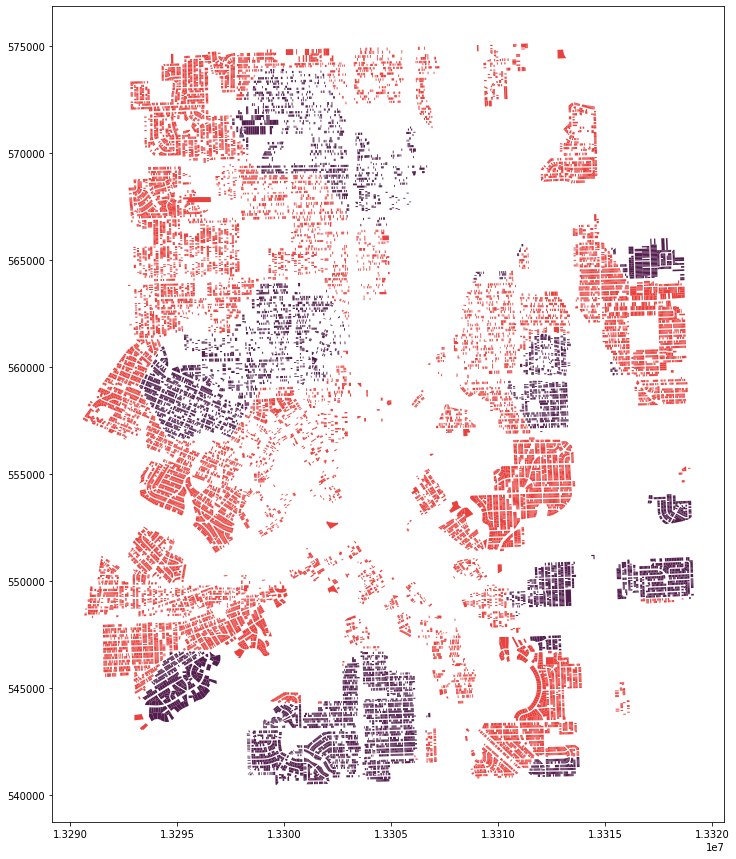

In [7]:
hexagons_10.parcel_gdf.plot(figsize = (15,15), color = hexagons_10.parcel_gdf['colors'])

In [8]:
train_pid_.keys()

dict_keys(['ts_0.1', 'ts_0.3', 'ts_0.4', 'ts_0.6', 'ts_0.7', 'ts_0.9'])

In [10]:
test_pid_sample_ = test_pid_['ts_0.3']['res_10'][0]
Xdata_.loc[test_pid_sample_]

,Homestead Percent,HomeSEV,Land Value,Land Improvements Value,Residential Building Value,Commercial Building Value,Parcel Acres,Year Built,SL_Lead,Ed_July,...,CENTRACT_3800,CENTRACT_4000,CENTRACT_13500,CENTRACT_13600,CENBLOCK_1,CENBLOCK_2,CENBLOCK_3,CENBLOCK_4,CENBLOCK_5,CENBLOCK_6
pid,,,,,,,,,,,,,,,,,,,,,
4012482018,100.0,18400,932,0,35843,0.0,0.140,2,0,0.0,...,0,0,0,0,0,1,0,0,0,0
4013226009,100.0,11800,420,0,23227,0.0,0.050,2,0,0.0,...,0,0,0,0,0,1,0,0,0,0
4012476011,0.0,0,602,0,18180,0.0,0.051,1912,0,0.0,...,0,0,0,0,0,1,0,0,0,0
4012481022,50.0,4550,781,0,17452,0.0,0.086,2,0,0.0,...,0,0,0,0,0,1,0,0,0,0
4013226025,100.0,12800,510,0,25104,0.0,0.070,1900,0,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4003477003,100.0,0,3750,0,209364,0.0,0.287,1964,0,0.0,...,0,0,0,0,0,1,0,0,0,0
4003479015,100.0,20300,3164,12498,157267,0.0,0.272,1954,0,0.0,...,0,0,0,0,0,1,0,0,0,0
4002306060,100.0,17900,3937,253,158421,0.0,0.324,1944,1,0.0,...,0,0,0,0,0,1,0,0,0,0


In [3]:
from blue_conduit_spatial.utilities import load_predictions, select_data

pred_dir = f'{data_dir}/predictions'
bl_preds_train, bl_preds_test = load_predictions(pred_dir, probs_prefix='baseline')

In [4]:
train_pred_all = bl_preds_train
test_pred_all = bl_preds_test

In [5]:
data_selec = select_data(Xdata_, Ydata_, location_, train_pid_, test_pid_, train_pred_all, test_pred_all, 
                         train_size=0.3, split=0)

In [6]:
data_selec.keys()

dict_keys(['train_pid', 'test_pid', 'Xtrain', 'Xtest', 'Ytrain', 'Ytest', 'train_pred', 'test_pred'])